# Generative Adversarial Network

#### We are building a Generative Adversarial Network which draws apple doodles such that after training the model its hard to distinguish the drawings between the human-drawn and model-drawn doodles

#### Load Dependencies 

In [0]:
import numpy as np
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Load data

#### We are using the hand drawn doodles of apple as our dataset (aggragated by quickdraw initative of google) which can be found here: https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving apple.npy to apple.npy
User uploaded file "apple.npy" with length 113462128 bytes


In [0]:
input_images = 'apple.npy'

In [0]:
data = np.load(input_images)

In [9]:
data.shape

(144722, 784)

In [10]:
data[4343]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  46,  69,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 163, 209,   0,   0,  46, 122, 171,  84,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 170, 207,  42, 171, 254, 255, 249,
        88,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 174, 232, 253, 255, 255,
       215,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 178, 233, 255,
       255, 151,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [11]:
data = data/255
data = np.reshape(data, (data.shape[0], 28, 28, 1))
img_w, img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [12]:
data[4343]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.18039216],
        [0.27058824],
        [0.        ],
        [0.        ],
        

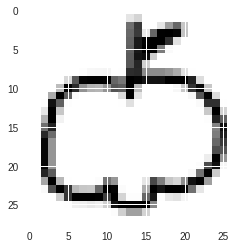

In [13]:
plt.imshow(data[4343,:,:,0], cmap='Greys')

#### Create Discriminator network

In [0]:
def discriminator_builder(width=64, p=0.4):
    
    # define inputs:
    inputs = Input((img_w, img_h, 1))
    
    # convolutional layers:
    conv1 = Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # output layer:
    output = Dense(1, activation='sigmoid')(conv4)
    
    # model definition:
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [15]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [0]:
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), metrics=['accuracy'])

#### Create Generator network

In [0]:
def generator_builder(z_dim=100, width=64, p=0.4):
    
    # define inputs:
    inputs = Input((z_dim,))
    
    # first dense layer:
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # deconvolutional layers:
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(width/2), kernel_size=5, padding='same', activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(width/4), kernel_size=5, padding='same', activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(width/8), kernel_size=5, padding='same', activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    # output layer:
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    # model definition:
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [18]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
__________

#### Create adversarial network

In [0]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), metrics=['accuracy'])
    
    model.summary()
    
    return model

In [20]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


#### Train the network

In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [0]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0
100
200
300
400
Epoch #500
499: [D loss: 0.531385, acc: 0.759597]  [A loss: 1.750496, acc: 0.101061]


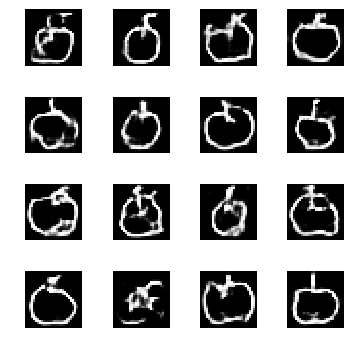

500
600
700
800
900
Epoch #1000
999: [D loss: 0.580390, acc: 0.707422]  [A loss: 1.500094, acc: 0.110126]


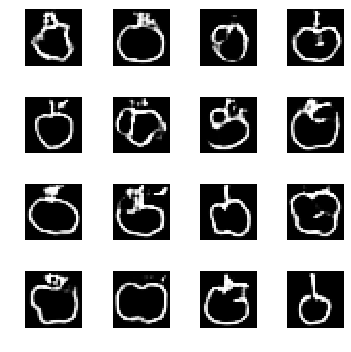

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.588954, acc: 0.698507]  [A loss: 1.459509, acc: 0.115801]


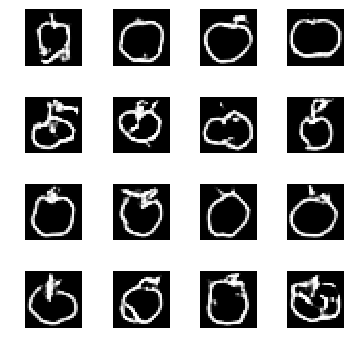

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.584638, acc: 0.703141]  [A loss: 1.506138, acc: 0.115315]


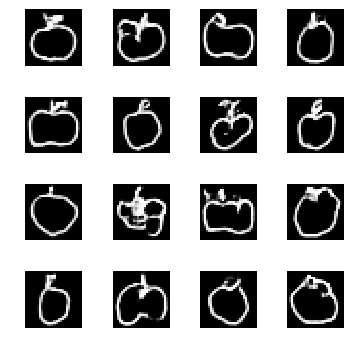

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.578497, acc: 0.709201]  [A loss: 1.590378, acc: 0.113492]


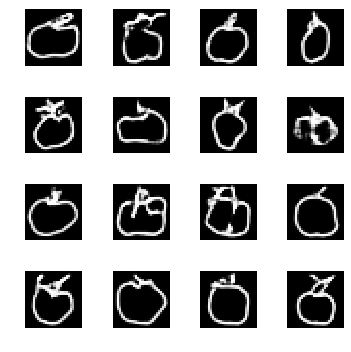

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.570903, acc: 0.716454]  [A loss: 1.690350, acc: 0.110422]


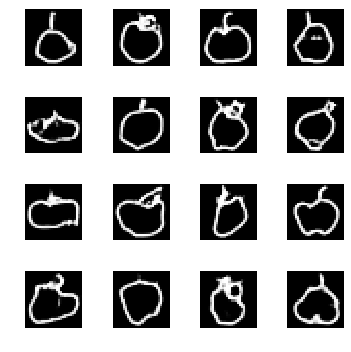

In [23]:
a_metrics_complete, d_metrics_complete = train(epochs=3000)

Text(0,0.5,'Loss')

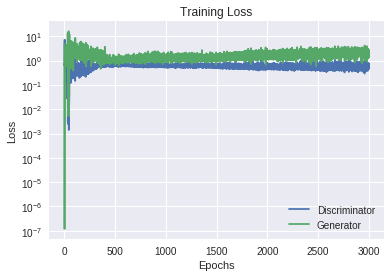

In [24]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0,0.5,'Accuracy')

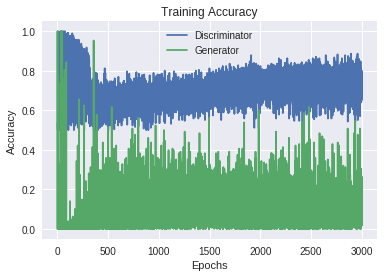

In [25]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")